In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    from google.colab import drive
    my_path = 'drive/My Drive/techlabs/'
    drive.mount('/content/drive')
except:
    my_path = 'dados/'

Mounted at /content/drive


In [3]:
df = pd.read_pickle(my_path + 'final-3.6.pkl.xz')
df = df.reset_index(drop=True)

In [4]:
provas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
colunas = [ col for col in df.columns if col not in provas ]
colunas.remove('TP_STATUS_REDACAO')

In [5]:
import json

with open(my_path + 'categorias.json', 'r') as f:
    c = json.load(f)
    categorias = {
        **c['participante'], **c['escola'], **c['especializado'], **c['especifico'],
        **c['recurso'], **c['local_prova'], **c['prova'], **c['redacao'], **c['socioeconomico']
    }

In [6]:
df_categoria = df[provas + colunas].copy()
for c in colunas:
    try:
        df_categoria[c] = df[c].cat.codes
    except:
        pass

In [7]:
df_categoria.corr().loc[provas, :]

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_LINGUA,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q022,Q023,Q024,Q025,IN_ESPECIALIZADO,IN_ESPECIFICO,IN_RECURSO
NU_NOTA_CN,1.000000,0.669247,0.642877,0.648031,0.505337,-0.056845,-0.124755,-0.033126,-0.190884,-0.035119,0.002829,0.018426,0.051999,-0.101907,-0.028886,-0.256514,0.219245,0.264942,0.215366,0.241951,-0.096532,0.430519,0.174082,0.329698,0.196888,0.312548,-0.035608,0.122688,0.236687,0.223241,0.378234,0.220502,0.006405,-0.006035,0.009754
NU_NOTA_CH,0.669247,1.000000,0.745167,0.610630,0.530075,-0.032498,-0.078844,-0.022710,-0.184918,-0.040501,-0.010381,0.047753,0.040913,-0.075766,-0.015729,-0.248580,0.200110,0.236123,0.202116,0.219573,-0.100599,0.393667,0.146438,0.290862,0.172750,0.275362,-0.048449,0.108905,0.226607,0.213701,0.354972,0.218823,0.000863,-0.005563,0.005561
NU_NOTA_LC,0.642877,0.745167,1.000000,0.589680,0.538595,-0.085970,-0.014272,-0.039353,-0.191544,-0.039693,-0.003908,0.018683,0.034232,-0.070637,-0.025911,-0.265564,0.217016,0.254847,0.220196,0.230215,-0.106688,0.389440,0.137567,0.288358,0.169631,0.277699,-0.055372,0.111154,0.248836,0.220519,0.352997,0.241907,-0.015679,-0.004510,-0.008349
NU_NOTA_MT,0.648031,0.610630,0.589680,1.000000,0.495625,-0.139390,-0.188220,-0.056428,-0.196824,-0.032020,0.053683,-0.051538,0.087851,-0.092934,-0.055879,-0.268104,0.235678,0.293339,0.225162,0.255613,-0.076601,0.463578,0.200742,0.356287,0.222478,0.341254,-0.018214,0.133932,0.258537,0.226816,0.389998,0.230018,0.001739,-0.008126,0.005100
NU_NOTA_REDACAO,0.505337,0.530075,0.538595,0.495625,1.000000,-0.167270,0.038385,-0.065809,-0.124368,-0.026433,-0.000798,-0.066168,0.082024,0.007637,0.001331,-0.175340,0.169294,0.222202,0.155199,0.178947,-0.052598,0.315349,0.131457,0.247698,0.160086,0.220144,-0.026887,0.085100,0.197404,0.152757,0.268689,0.178082,-0.007560,-0.007966,-0.001631


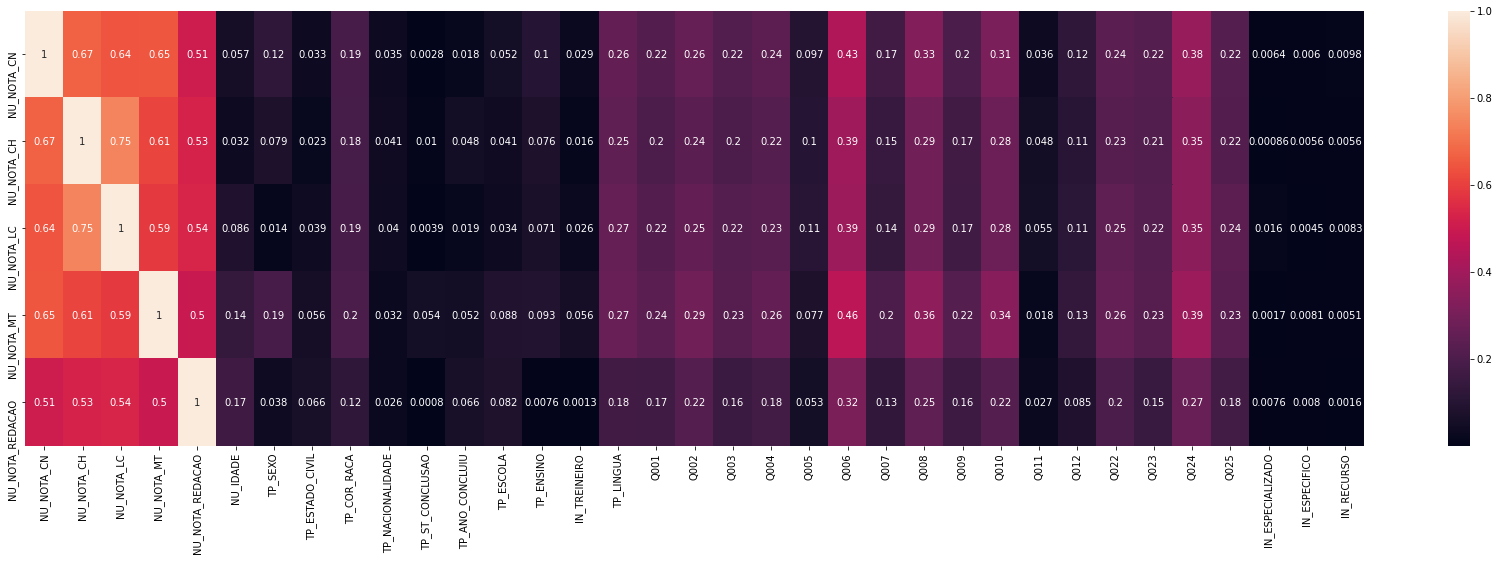

In [8]:
plt.figure(figsize=(30,8))
corr = df_categoria.corr().loc[provas, :].abs()
sns.heatmap(corr, annot=corr, vmax=1)

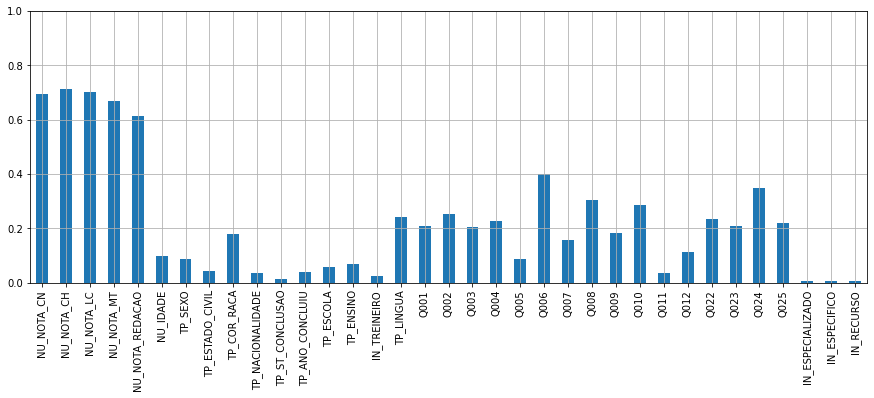

In [9]:
plt.figure(figsize=(15,5))
corr.mean().plot.bar(ylim=(0,1.0), grid=True)

# Machine Learning

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_log_error, max_error, mean_absolute_error

In [11]:
def regressorOneColumnY(X, y, regressorClass, **regr_kwargs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=1245
    )

    regr = regressorClass(**regr_kwargs)
    regr.fit(X_train, y_train)

    y_predict = regr.predict(X_test)

    result = (y.name, explained_variance_score(y_test, y_predict), mean_absolute_error(y_test, y_predict), max_error(y_test, y_predict))
    print('{:>15} {:.5f} {:.5f} {:.5f}'.format(*result))
    return result

In [12]:
def prova_por_prova(df_limpa, regressorClass, **regr_kwargs):
    results = []
    for p in provas:
        X = pd.get_dummies(df_limpa.loc[:, df_limpa.columns != p])
        y = df_limpa[p]
        results.append(regressorOneColumnY(X, y, regressorClass, **regr_kwargs))
    return results

In [13]:
def ml_por_valor_minimo(valor, regressorClass, **regr_kwargs):
    minimo = valor
    colunas = [ c for c in corr.columns[corr.mean() > minimo] ]
    df_ml = df[colunas].loc[df[colunas].notnull().all(axis=1), :]

    print(minimo, df_ml.columns)
    print('Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"\n')
    return prova_por_prova(df_ml, regressorClass, **regr_kwargs)

In [14]:
def ml_todos_exceto_provas(regressorClass, **regr_kwargs):
    df_ml = df[corr.columns].loc[
        df[corr.columns].notnull().all(axis=1), corr.columns
    ]

    results = []
    print('colunas: ')
    print("['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', ")
    print("    'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', ")
    print("    'TP_LINGUA', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', ")
    print("    'Q010', 'Q011', 'Q012', 'Q022', 'Q023', 'Q024', 'Q025', 'IN_ESPECIALIZADO', 'IN_ESPECIFICO', 'IN_RECURSO']")
    print('Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"\n')
    for p in provas:
        X = pd.get_dummies(df_ml.loc[:, [ c for c in df_ml.columns if c not in provas ]])
        y = df_ml[p]
        results.append(regressorOneColumnY(X, y, regressorClass, **regr_kwargs))
    return results

In [15]:
resultados = {}

## Dummy Regressor

In [16]:
from sklearn.dummy import DummyRegressor

def run_dummy_regressor(valor):
    return ml_por_valor_minimo(valor, DummyRegressor, strategy="mean")

In [17]:
exceto_provas = ml_todos_exceto_provas(DummyRegressor, strategy="mean")

colunas: 
['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 
    'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 
    'TP_LINGUA', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 
    'Q010', 'Q011', 'Q012', 'Q022', 'Q023', 'Q024', 'Q025', 'IN_ESPECIALIZADO', 'IN_ESPECIFICO', 'IN_RECURSO']
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.00000 59.82418 471.19086
     NU_NOTA_CH 0.00000 63.71052 504.17136
     NU_NOTA_LC 0.00000 47.87051 518.28949
     NU_NOTA_MT 0.00000 84.62434 514.47870
NU_NOTA_REDACAO 0.00000 129.14784 580.72290


In [18]:
a = run_dummy_regressor(0.3)

0.3 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q006', 'Q008', 'Q024'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.00000 63.07232 477.89218
     NU_NOTA_CH 0.00000 66.12944 509.89328
     NU_NOTA_LC 0.00000 49.32933 522.40771
     NU_NOTA_MT 0.00000 90.10294 523.24615
NU_NOTA_REDACAO 0.00000 132.55246 579.83209


In [19]:
b = run_dummy_regressor(0.35)

0.35 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q006'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.00000 63.07232 477.89218
     NU_NOTA_CH 0.00000 66.12944 509.89328
     NU_NOTA_LC 0.00000 49.32933 522.40771
     NU_NOTA_MT 0.00000 90.10294 523.24615
NU_NOTA_REDACAO 0.00000 132.55246 579.83209


In [20]:
c = run_dummy_regressor(0.4)

0.4 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.00000 63.07232 477.89218
     NU_NOTA_CH 0.00000 66.12944 509.89328
     NU_NOTA_LC 0.00000 49.32933 522.40771
     NU_NOTA_MT 0.00000 90.10294 523.24615
NU_NOTA_REDACAO 0.00000 132.55246 579.83209


In [21]:
resultados['dummy'] = (exceto_provas, a, b, c)

## Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

def run_linear_regression(valor):
    return ml_por_valor_minimo(valor, LinearRegression)

In [23]:
exceto_provas = ml_todos_exceto_provas(LinearRegression)

colunas: 
['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 
    'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 
    'TP_LINGUA', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 
    'Q010', 'Q011', 'Q012', 'Q022', 'Q023', 'Q024', 'Q025', 'IN_ESPECIALIZADO', 'IN_ESPECIFICO', 'IN_RECURSO']
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.24393 51.15700 584.77344
     NU_NOTA_CH 0.22413 55.11356 596.35645
     NU_NOTA_LC 0.25026 40.80415 584.22461
     NU_NOTA_MT 0.28852 70.24385 674.51562
NU_NOTA_REDACAO 0.17371 118.76622 841.93750


In [24]:
a = run_linear_regression(0.3)

0.3 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q006', 'Q008', 'Q024'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.57277 39.56565 626.59534
     NU_NOTA_CH 0.63745 37.33591 633.38733
     NU_NOTA_LC 0.62103 29.03033 555.85461
     NU_NOTA_MT 0.52640 60.23179 666.69019
NU_NOTA_REDACAO 0.36833 106.70522 916.34723


In [25]:
b = run_linear_regression(0.35)

0.35 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q006'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.57139 39.63287 624.41473
     NU_NOTA_CH 0.63696 37.36345 631.88232
     NU_NOTA_LC 0.62018 29.06752 554.77026
     NU_NOTA_MT 0.52411 60.38047 673.86932
NU_NOTA_REDACAO 0.36768 106.76864 915.85162


In [26]:
c = run_linear_regression(0.4)

0.4 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.56576 39.89288 614.75793
     NU_NOTA_CH 0.63620 37.39812 628.02771
     NU_NOTA_LC 0.61630 29.22213 553.27228
     NU_NOTA_MT 0.50175 61.89783 629.22583
NU_NOTA_REDACAO 0.36663 106.94009 909.58813


In [27]:
resultados['linear'] = (exceto_provas, a, b, c)

## Decision Tree

In [28]:
from sklearn.tree import DecisionTreeRegressor

def run_decision_tree(valor):
    return ml_por_valor_minimo(valor, DecisionTreeRegressor, max_depth=10)

In [29]:
exceto_provas = ml_todos_exceto_provas(DecisionTreeRegressor, max_depth=10)

colunas: 
['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 
    'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 
    'TP_LINGUA', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 
    'Q010', 'Q011', 'Q012', 'Q022', 'Q023', 'Q024', 'Q025', 'IN_ESPECIALIZADO', 'IN_ESPECIFICO', 'IN_RECURSO']
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.22658 51.75351 592.91595
     NU_NOTA_CH 0.20689 55.79218 608.57095
     NU_NOTA_LC 0.22704 41.44436 583.60000
     NU_NOTA_MT 0.26928 71.12720 706.48018
NU_NOTA_REDACAO 0.16414 119.36995 880.00000


In [30]:
a = run_decision_tree(0.3)

0.3 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q006', 'Q008', 'Q024'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.59572 38.55326 647.21757
     NU_NOTA_CH 0.64734 36.94651 641.79999
     NU_NOTA_LC 0.62229 28.91056 595.00000
     NU_NOTA_MT 0.55324 58.28520 801.29999
NU_NOTA_REDACAO 0.36901 106.62739 1000.00000


In [31]:
b = run_decision_tree(0.35)

0.35 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q006'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.59542 38.57387 647.21757
     NU_NOTA_CH 0.64730 36.94673 641.79999
     NU_NOTA_LC 0.62215 28.91228 565.50000
     NU_NOTA_MT 0.55290 58.28654 801.29999
NU_NOTA_REDACAO 0.36878 106.67979 1000.00000


In [32]:
c = run_decision_tree(0.4)

0.4 Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO'],
      dtype='object')
Parâmetros: "explained_variance_score"  "mean_absolute_error"  "max_error"

     NU_NOTA_CN 0.59523 38.57620 647.21757
     NU_NOTA_CH 0.64728 36.94599 641.79999
     NU_NOTA_LC 0.62224 28.91796 565.50000
     NU_NOTA_MT 0.54870 58.59145 801.29999
NU_NOTA_REDACAO 0.36891 106.67257 1000.00000


In [33]:
resultados['tree'] = (exceto_provas, a, b, c)

## SVM 

Pulado devido ao treino/predição passarem de 30 minutos de execução

## Conclusões

- Realmente é preciso usar as notas na predição, caso contrário não teremos um resultado razoável
- Quanto maior a quantidade de variáveis, mais tempo demora pra executar
- Por ser simples, o DummyRegressor nem serviu para o nosso caso
- O LinearRegression e o DecisionTreeRegressor tiveram um resultado semelhante
- As predições podem ser feitas com uma margem de erro considerável.
- As notas que tiveram pior resultado de predição foram as notas de matemática e redação. Com 50% e 37% de precisão e 60 e 107 pontos na margem de erro para as duas provas.